In [9]:
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import neighbors
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import warnings
# Suppress annoying harmless error.
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set()

%matplotlib inline

In [2]:
# Read Iris dataset

iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target

df = sns.load_dataset("iris")
# lets replace the species with an integer
z = {"setosa": 1, "virginica": 2, "versicolor": 3}
df["species_num"] = df.species.map(z) 

In [3]:
# Split

np.random.seed(0)
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-30]]
iris_y_train = iris_y[indices[:-30]]
iris_X_test = iris_X[indices[-30:]]
iris_y_test = iris_y[indices[-30:]]

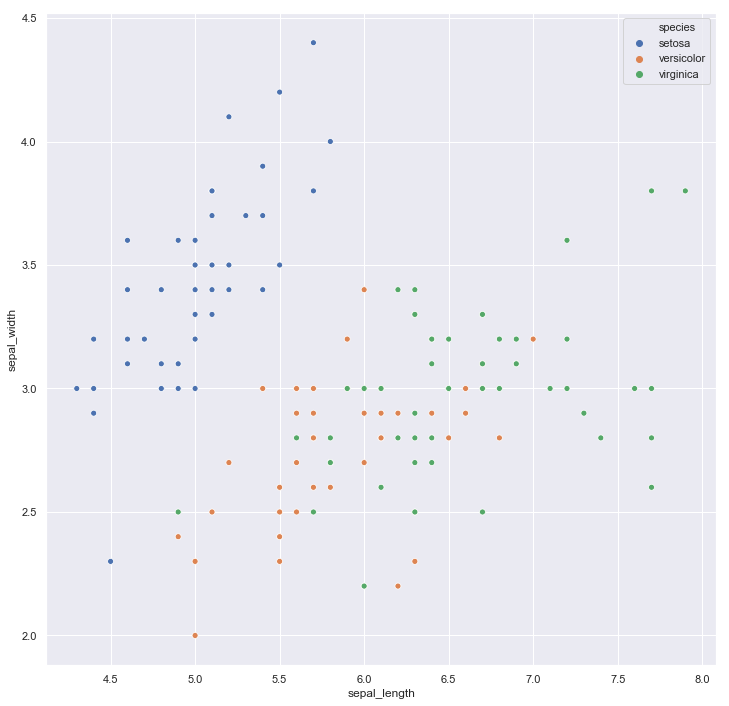

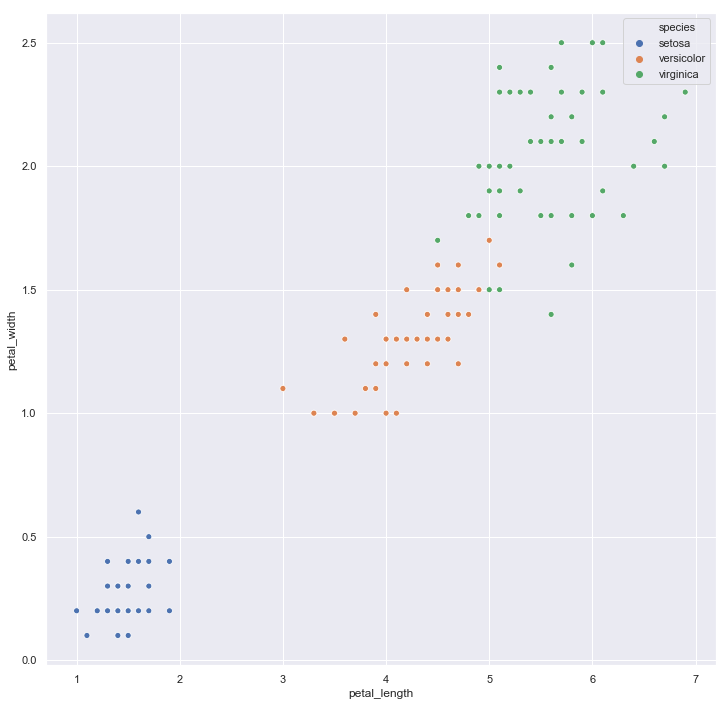

In [4]:
plt.figure(figsize=(12,12))
sns.scatterplot('sepal_length', 'sepal_width', hue='species', data=df)
plt.show()

plt.figure(figsize=(12,12))
sns.scatterplot('petal_length', 'petal_width', hue='species', data=df)
plt.show()

*Let us add some dummy variables for distinguishing virginica from versicolor species.*

In [5]:
df["petal_length_high"] = np.where(df["petal_length"] > 6.0, 1, 0)
df["petal_width_high"] = np.where(df["petal_width"] > 1.5, 1, 0)
df["petal_length_low"] = np.where(df["petal_length"] < 2.0, 1, 0)

In [6]:
train = df.sample(frac=0.8, random_state=41)
test = df.iloc[~df.index.isin(train.index)]

# Regression

This is a classification task, so regression doesn't really make sense. However, to demonstrate it's downfalls for this application, we are going to use partial least squares regression, but first we need to transform our input features as they are all very collinear. We can log everything (essentially performing logistic-regression), or PCA the 4 input features. We will try both methods.

## Linear Regression

In [7]:
# Need to transform variables
features = ['sepal_length', 'sepal_width', 
            'petal_length', 'petal_width']
formula = "species_num ~ " + ' + '.join(features)
lm1 = smf.ols(formula, data=train).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            species_num   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     38.88
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           1.48e-20
Time:                        12:25:28   Log-Likelihood:                -94.593
No. Observations:                 120   AIC:                             199.2
Df Residuals:                     115   BIC:                             213.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.7832      0.594      4.687      0.000       1.607       3.959
sepal_length    -0.0173      0.158     -0.110      0.913      -0.330       0.296
sepal_width     -0.6053      0.165     -3.673      0.000      -0.932      -0.279
petal_length     0.4911      0.156      3.152      0.002       0.183       0.800
petal_width     -0.5678      0.267     -2.127      0.036      -1.096      -0.039
==============================================================================
Omnibus:                       11.941   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                4.953
Skew:                           0.227   Prob(JB):                       0.0840
Kurtosis:                       2.114   Cond. No.                         95.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The reported p-values indicate that sepal length is not necessary, so let's remove this one and add our custom indicator variables.

In [8]:
# Need to transform variables
features2 = ['sepal_width', 'petal_length_low',
            'petal_length', 'petal_width', 
            'petal_width_high']
formula2 = "species_num ~ " + ' + '.join(features2)
lm2 = smf.ols(formula2, data=train).fit()
print(lm2.summary())

train["pred_species_num"] = 0
test["pred_species_num"] = 0

                            OLS Regression Results                            
Dep. Variable:            species_num   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     341.3
Date:                Wed, 19 Dec 2018   Prob (F-statistic):           7.84e-67
Time:                        12:25:35   Log-Likelihood:                 20.323
No. Observations:                 120   AIC:                            -28.65
Df Residuals:                     114   BIC:                            -11.92
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.5971      0.222  

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


*This model looks much more promising than the first!*  
Now keep in mind that this model predicts a continuous species number (originally 1, 2 and 3), so we need to specify some thresholds to categorize our results. 

  1. 0.0 < setosa < 1.5
  2. 1.5 < versicolor < 2.4
  3. virginica > 2.4

In [10]:
# these are all of setosa
train.loc[lm2.fittedvalues.between(0,1.5), "pred_species_num"] = 1
train.loc[lm2.fittedvalues.between(1.5,2.4), "pred_species_num"] = 2
train.loc[lm2.fittedvalues>2.4,"pred_species_num"] = 3

In [11]:
# now make some predictions on the test set
pred = lm2.predict(test)
test.loc[pred.between(0,1.5), "pred_species_num"] = 1
test.loc[pred.between(1.5,2.4), "pred_species_num"] = 2
test.loc[pred>2.4,"pred_species_num"] = 3

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [185]:
print("R-squared (Train): {:.4f}".format(r2_score(train.species_num, train.pred_species_num)))
print("R-squared (Test): {:.4f}".format(r2_score(test.species_num, test.pred_species_num)))

R-squared (Train): 0.9250
R-squared (Test): 1.0000


# KNN

In [12]:
# Create and fit a nearest-neighbor classifier
knn = KNeighborsClassifier()
knn.fit(iris_X_train, iris_y_train)
knn.predict(iris_X_test)

array([0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 0, 1, 1, 2,
       1, 0, 0, 0, 2, 1, 2, 0])

In [24]:
np.random.seed(0)
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-30]]
iris_y_train = iris_y[indices[:-30]]
iris_X_test = iris_X[indices[-30:]]
iris_y_test = iris_y[indices[-30:]]
# Create and fit a nearest-neighbor classifier

# Unweighted (uniform)
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(iris_X_train, iris_y_train) 
y_pred_train = knn.predict(iris_X_train)
y_pred_test = knn.predict(iris_X_test)
print("KNN Score (Train): {}".format(knn.score(iris_X_train, iris_y_train)))
print("KNN Score (Test): {}".format(knn.score(iris_X_test, iris_y_test)))

KNN Score (Train): 0.9833333333333333
KNN Score (Test): 0.9666666666666667


In [25]:
# Weighted by distance
knn_w = KNeighborsClassifier(n_neighbors=8, weights="distance")
knn_w.fit(iris_X_train, iris_y_train) 
y_pred_train = knn_w.predict(iris_X_train)
y_pred_test = knn_w.predict(iris_X_test)
print("KNN Score (Train): {}".format(knn_w.score(iris_X_train, iris_y_train)))
print("KNN Score (Test): {}".format(knn_w.score(iris_X_test, iris_y_test)))

KNN Score (Train): 1.0
KNN Score (Test): 0.9333333333333333


So the weighted model performs better on the train set, but both models perform the same on the test set.

# Conclusion

The task at hand with this dataset is to predict the species of Iris plants based on petal length and width as well as sepal length and width. This is a very famous dataset, and by nature is a classification task. This leads me to suspect that the KNN model will be much better at this job than a linear regression model. However, if you plot the input features against each other (with different colors for the species), we see that the setosa species is entirely linearly separable from the 2 other species, and the remaining 2 are also linearly separable. All we have to do in order to construct a really good regression model is to determine these "thresholds", and then add dummy/indicator variables to represent this information. Using these features, our model achieves an R-squared value of 0.925 on the train set, and a perfect 1.0 on the test set. 

Regarding a KNN classifier model, the unweighted model achieves better performance (on the test set), at 0.966 versus 0.933 for the weighted model. I also tuned k and found a k of 8 results in the best performance.